# Models Inference

In [1]:
import dill
import pickle
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool

from uncertainty import ensemble_uncertainties_regression
from plot_utils import fast_plot, fast_hist, fast_legend, feature_snapshot, fast_scatter

In [2]:
def get_predictions(features_df, model):
    '''
    Calculates predictions on df features for specified model
    
    Return: array [num_samples x 2],
        where
            num_samples = number of rows in features_df
            2 = [mean, variance]
    
    '''
    return model.predict(features_df)


def get_all_predictions_mixed(features_df, models_list, features_df_2, models_list_2):
    '''
    Return: array [ensemble_size x num_samples x 2],
        where
            ensemble_size = number of models in models_list
            num_samples = number of rows in features_df
            2 = [mean, variance]
    '''
    all_preds = []
    for model in models_list:
        preds = np.asarray(get_predictions(features_df, model))
        all_preds.append(preds)
        
    for model in models_list_2:
        preds = np.asarray(get_predictions(features_df_2, model))
        all_preds.append(preds)
    return np.stack(all_preds, axis=0)

## Load data

In [3]:
%%time

with open('../data/processed/train.pcl', 'rb') as f:
    train = pickle.load(f)
    
with open('../data/processed/test.pcl', 'rb') as f:
    test = pickle.load(f)
    
train = train.sort_values(['fact_temperature', 'climate', 'fact_cwsm_class', 
                           'fact_latitude', 'fact_longitude', 'fact_time'])

train.index = [x for x in range(train.shape[0])]
test.index = [x for x in range(test.shape[0])]

print('Train:', train.shape)
print('Test:', test.shape, '\n')

Train: (3129592, 131)
Test: (1137731, 125) 

Wall time: 3.77 s


## Feature sets

In [4]:
target = 'fact_temperature'
features = list(train.columns[6:]) 
features2 = ['x1', 'wrf_t2', 'x2', 'gfs_temperature_sea', 'cmc_0_0_0_2_interpolated',
             'gfs_temperature_sea_interpolated', 'wrf_t2_interpolated',
             'cmc_0_0_0_1000', 'topography_bathymetry', 'cmc_0_0_0_2',
             'sun_elevation', 'wrf_t2_next', 'gfs_pressure', 'gfs_soil_temperature',
             'climate_pressure', 'cmc_0_3_0_0_next', 'wrf_rh2', 'cmc_0_3_0_0',
             'climate_temperature', 'cmc_0_0_0_2_grad', 'gfs_temperature_10000',
             'gfs_humidity', 'cmc_0_1_0_0', 'cmc_0_0_7_925', 'gfs_wind_speed',
             'gfs_temperature_5000', 'gfs_a_vorticity', 'gfs_temperature_97500',
             'gfs_temperature_7000', 'wrf_psfc', 'wrf_wind_u',
             'gfs_total_clouds_cover_low_next', 'cmc_0_2_2_500', 'gfs_r_velocity',
             'gfs_temperature_sea_grad', 'cmc_0_0_0_850', 'cmc_timedelta_s',
             'wrf_wind_v', 'gfs_precipitable_water', 'cmc_0_3_5_850', 'cmc_0_2_3_10',
             'cmc_0_0_7_2', 'cmc_0_0_0_925', 'cmc_0_0_7_850', 'cmc_0_3_5_925',
             'gfs_temperature_25000', 'cmc_0_3_1_0', 'gfs_temperature_95000',
             'wrf_t2_grad', 'gfs_2m_dewpoint_next', 'cmc_0_2_2_700', 'cmc_0_2_3_925',
             'gfs_cloudness', 'gfs_temperature_20000', 'cmc_0_2_3_500',
             'gfs_temperature_80000', 'gfs_temperature_15000', 'cmc_0_0_6_2',
             'gfs_total_clouds_cover_low', 'cmc_0_2_2_1000']
features

['topography_bathymetry',
 'sun_elevation',
 'climate_temperature',
 'climate_pressure',
 'cmc_0_0_0_1000',
 'cmc_0_0_0_2_grad',
 'cmc_0_0_0_2_interpolated',
 'cmc_0_0_0_2_next',
 'cmc_0_0_0_2',
 'cmc_0_0_0_500',
 'cmc_0_0_0_700',
 'cmc_0_0_0_850',
 'cmc_0_0_0_925',
 'cmc_0_0_6_2',
 'cmc_0_0_7_1000',
 'cmc_0_0_7_2',
 'cmc_0_0_7_500',
 'cmc_0_0_7_700',
 'cmc_0_0_7_850',
 'cmc_0_0_7_925',
 'cmc_0_1_0_0',
 'cmc_0_1_11_0',
 'cmc_0_1_65_0',
 'cmc_0_1_66_0',
 'cmc_0_1_67_0',
 'cmc_0_1_68_0',
 'cmc_0_1_7_0',
 'cmc_0_2_2_10',
 'cmc_0_2_2_1000',
 'cmc_0_2_2_500',
 'cmc_0_2_2_700',
 'cmc_0_2_2_850',
 'cmc_0_2_2_925',
 'cmc_0_2_3_10',
 'cmc_0_2_3_1000',
 'cmc_0_2_3_500',
 'cmc_0_2_3_700',
 'cmc_0_2_3_850',
 'cmc_0_2_3_925',
 'cmc_0_3_0_0',
 'cmc_0_3_0_0_next',
 'cmc_0_3_1_0',
 'cmc_0_3_5_1000',
 'cmc_0_3_5_500',
 'cmc_0_3_5_700',
 'cmc_0_3_5_850',
 'cmc_0_3_5_925',
 'cmc_0_6_1_0',
 'cmc_available',
 'cmc_horizon_h',
 'cmc_precipitations',
 'cmc_timedelta_s',
 'gfs_2m_dewpoint',
 'gfs_a_vorticity'

## Load models

In [5]:
%%time
# Uncertainty estimation models

# Orange uncertainty models
uncert_orange = []

n_models = 200
folds = 25
calculated_models = 50

for model_number in range(calculated_models):
    model = CatBoostRegressor()
    model.load_model(f'../models/orange_box_{model_number}_{folds}_{n_models}.cbm')
    uncert_orange.append(model)

    
# Bronze uncertainty models 
uncert_bronze = []

n_models = 200
folds = 25
calculated_models = 27

for model_number in range(calculated_models):
    model = CatBoostRegressor()
    model.load_model(f'../models/bronze_box_{model_number}_{folds}_{n_models}.cbm')
    uncert_bronze.append(model)
    
print('Orange models:', len(uncert_orange))
print('Bronze models:', len(uncert_bronze))

Orange models: 50
Bronze models: 27
Wall time: 774 ms


In [6]:
%%time
# Temperature prediction models

# Purple + Aqua rmse models
rmse_purple_aqua = []

## Purple
n_models = 50
folds = 25
calculated_models = 32

for model_number in range(calculated_models):
    model = CatBoostRegressor()
    model.load_model(f'../models/purple_box_{model_number}_{folds}_{n_models}.cbm')
    rmse_purple_aqua.append(model)
    
## Aqua 
n_models = 20
folds = 20
calculated_models = 5

for model_number in range(calculated_models):
    model = CatBoostRegressor()
    model.load_model(f'../models/aqua_box_{model_number}_{folds}_{n_models}.cbm')
    rmse_purple_aqua.append(model)


# Silver rmse models
rmse_silver = []

n_models = 50
folds = 30
calculated_models = 12

for model_number in range(calculated_models):
    model = CatBoostRegressor()
    model.load_model(f'../models/silver_box_{model_number}_{folds}_{n_models}.cbm')
    rmse_silver.append(model)

    
print('Purple + Aqua models:', len(rmse_purple_aqua))
print('Silver models:', len(rmse_silver))

Purple + Aqua models: 37
Silver models: 12
Wall time: 6.42 s


# Local validation

In [7]:
def calculate_score(true, pred, uncertainties):
    df = pd.DataFrame(uncertainties.copy())
    df.columns = ['uncertainties']
    
    df['error'] = ((true.values - pred) ** 2)
    df = df.sort_values('uncertainties')
    df.index = range(df.shape[0])    
    
    score = df['error'].cumsum().mean() / df.shape[0]    
    return df, score

In [8]:
with open('../data/processed/dev_in.pcl', 'rb') as f:
    dev_in = pickle.load(f)
    
with open('../data/processed/dev_out.pcl', 'rb') as f:
    dev_out = pickle.load(f)

dev = pd.concat([dev_in, dev_out])
dev.index = range(dev.shape[0])

In [9]:
%%time
uncert_preds_dev = get_all_predictions_mixed(dev[features], uncert_orange, dev[features2], uncert_bronze)
all_uncertainty_dev = ensemble_uncertainties_regression(uncert_preds_dev)
uncertainties_dev = all_uncertainty_dev['tvar']

Wall time: 8.98 s


In [10]:
%%time
all_preds_dev = get_all_predictions_mixed(dev[features], rmse_purple_aqua, dev[features2], rmse_silver)
avg_preds_dev = np.squeeze(np.mean(all_preds_dev, axis=0))
preds_std_dev = all_preds_dev.std(axis=0)

Wall time: 1min


## Adjusting the uncertainty estimate by the standard deviation of the predictions
* The adjustment uses the normalization of the degree of uncertainty and standard deviations to their medians
* Since the uncertainty values ​​have very long tails, the log1p and double log1p transformations were applied to them

,std_rate,score,log_score,log_log_score
1252,1.252,1.045121,1.047612,1.054609


,std_rate,score,log_score,log_log_score
671,0.671,1.048367,1.042605,1.04404


,std_rate,score,log_score,log_log_score
443,0.443,1.052794,1.044359,1.041855


            std_rate       score
Original:               1.07260893
Unc - std: [[1.252      1.04512074]]
Log:       [[0.671     1.0426052]]
Log Log:   [[0.443      1.04185526]]
Wall time: 1min 24s


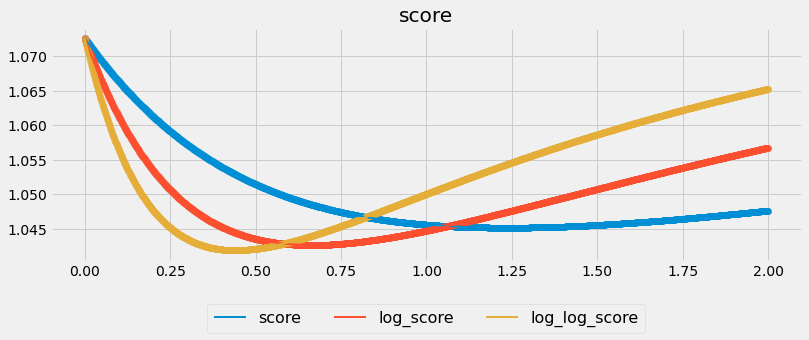

In [11]:
%%time
std_df = pd.DataFrame(np.linspace(0, 2, 2001), columns=['std_rate'])
std_df['score'] = np.NaN
std_df['log_score'] = np.NaN
std_df['log_log_score'] = np.NaN

for row in range(std_df.shape[0]):
    
    # Normalized uncertainties score - normalized std
    uncertainties2_dev = uncertainties_dev.copy()
    uncertainties2_dev = uncertainties2_dev/ np.median(uncertainties2_dev)
    uncertainties2_dev = uncertainties2_dev + preds_std_dev / np.median(preds_std_dev) * std_df['std_rate'].iloc[row]    
    
    df, score = calculate_score(dev[target], avg_preds_dev, uncertainties2_dev)
    std_df['score'].iloc[row] = score
    
    # Normalized Log1p uncertainties score - normalized std
    uncertainties3_dev = np.log1p(uncertainties_dev.copy())
    uncertainties3_dev /= np.median(uncertainties3_dev)
    uncertainties3_dev = uncertainties3_dev + preds_std_dev / np.median(preds_std_dev) * std_df['std_rate'].iloc[row]  

    df, score = calculate_score(dev[target], avg_preds_dev, uncertainties3_dev)
    std_df['log_score'].iloc[row] = score
    
    # Normalized Log1p Log1p uncertainties score - normalized std
    uncertainties4_dev = np.log1p(np.log1p(uncertainties_dev.copy()))
    uncertainties4_dev /= np.median(uncertainties4_dev)
    uncertainties4_dev = uncertainties4_dev + preds_std_dev / np.median(preds_std_dev) * std_df['std_rate'].iloc[row]  

    df, score = calculate_score(dev[target], avg_preds_dev, uncertainties4_dev)
    std_df['log_log_score'].iloc[row] = score
    
    
fast_plot(std_df.set_index('std_rate')['score'])
fast_plot(std_df.set_index('std_rate')['log_score'], new_figure=False)
fast_plot(std_df.set_index('std_rate')['log_log_score'], new_figure=False)

display(std_df[std_df['score'] == std_df['score'].min()])
display(std_df[std_df['log_score'] == std_df['log_score'].min()])
display(std_df[std_df['log_log_score'] == std_df['log_log_score'].min()])


df, score = calculate_score(dev[target], avg_preds_dev, uncertainties_dev)
print('            std_rate       score')
print(f'Original:               {round(score, 8)}')
print('Unc - std:', std_df[std_df['score'] == std_df['score'].min()][['std_rate', 'score']].values)
print('Log:      ', std_df[std_df['log_score'] == std_df['log_score'].min()][['std_rate', 'log_score']].values)
print('Log Log:  ', std_df[std_df['log_log_score'] == std_df['log_log_score'].min()][['std_rate', 'log_log_score']].values)

## Adjustment of uncertainty estimates due to differences in feature distributions
    1. For a pair of features x, y and a given grid step (the grid step is set in quantiles), the number of objects that 
       fall into certain square on the training set is calculated 
    2. For the test sample, the square in which the object is located is determined and how many objects correspond to this
       square, the more objects the more stable the forecast will be
* Features are selected taking into account catboost feature importance
* In pairs, the 'x1' feature is always present, the second is selected from the distribution_features list

In [12]:
distribution_features = ['x1', 'wrf_t2', 'x2', 'gfs_temperature_sea', 'cmc_0_0_0_2_interpolated',
                         'gfs_temperature_sea_interpolated', 'wrf_t2_interpolated',
                         'cmc_0_0_0_1000', 'topography_bathymetry', 'cmc_0_0_0_2',
                         'sun_elevation', 'gfs_pressure', 'gfs_soil_temperature', 'climate_pressure',
                         'cmc_0_3_0_0_next', 'wrf_rh2', 'climate_temperature', 'cmc_0_0_0_2_grad',
                         'gfs_temperature_10000', 'gfs_humidity', 'cmc_0_1_0_0', 'cmc_0_0_7_925',
                         'gfs_wind_speed', 'wrf_psfc', 'wrf_wind_u',
                         'gfs_temperature_sea_grad', 'cmc_timedelta_s']

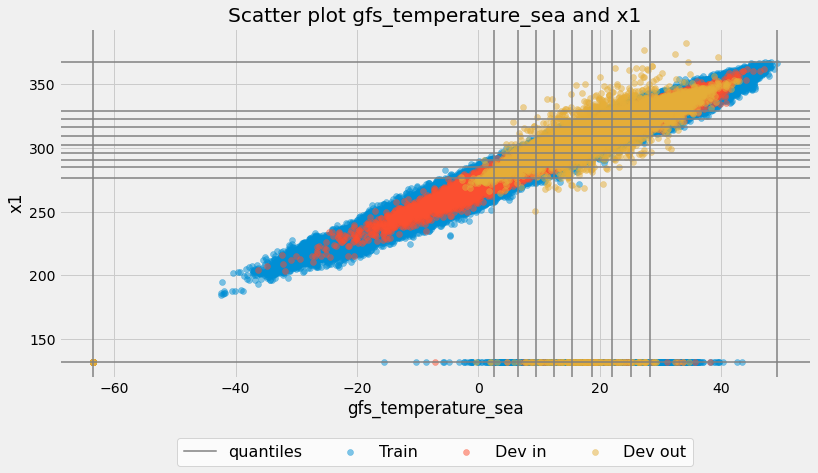

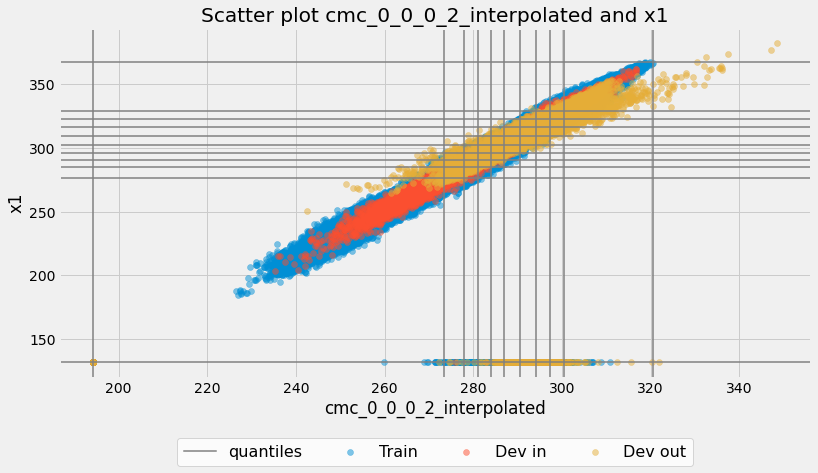

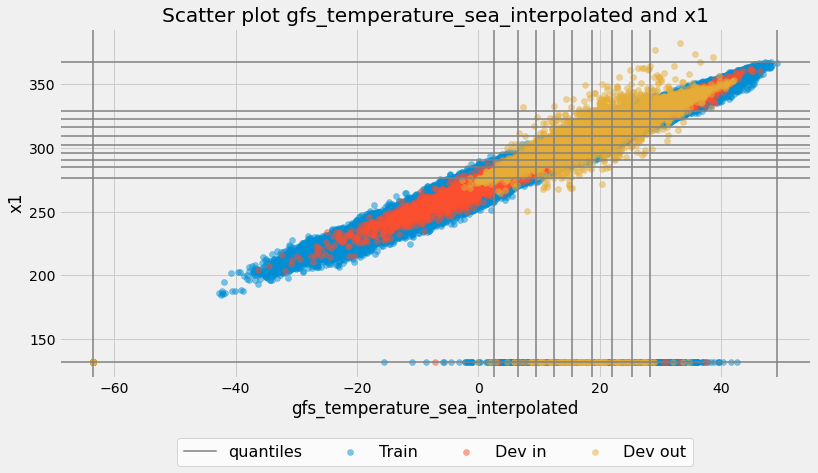

In [13]:
# Several scatter diagrams for selected features, quantiles for each feature are plotted in gray grid
# For each cell in the grid, the number of observations on the training sample will be counted
# Further, for each observation for all pairs of features, the sum of objects in the grids will be calculated

for feature in distribution_features[3:6]:
    title = f'Scatter plot {feature} and x1'
    
    fast_scatter(train[feature], train['x1'], figsize=(12, 6), label='Train', plot_legend=False, title=title)
    fast_scatter(dev_in[feature], dev_in['x1'], figsize=(12, 6), label='Dev in', new_figure=False)
    fast_scatter(dev_out[feature], dev_out['x1'], figsize=(12, 6), label='Dev out', new_figure=False)
    
    first_execution = True
    for q in np.linspace(0, 1, 11):
        if first_execution:
            plt.axvline(train[feature].quantile(q), color='grey', label='quantiles')
            first_execution = False
        else:
            plt.axvline(train[feature].quantile(q), color='grey')
        plt.axhline(train['x1'].quantile(q), color='grey')
    
    fast_legend(ncol=4)
    plt.show();

In [14]:
def distribution_count(train_data, test_data, feature1, feature2, bins=10):
    features = [feature1, feature2]
    print(features)
    qs = np.linspace(0, 1, bins + 1)

    train_data = train[features].copy()
    test_data = test_data[features].copy()
    test_data['counter'] = np.NaN

    train_masks_feature1 = []
    train_masks_feature2 = []
    test_masks_feature1 = []
    test_masks_feature2 = []


    for i in range(bins):
        feature1_min_value = train_data[feature1].quantile(qs[i])
        feature1_max_value = train_data[feature1].quantile(qs[i + 1])
        feature2_min_value = train_data[feature2].quantile(qs[i])
        feature2_max_value = train_data[feature2].quantile(qs[i + 1])
    
    
        # Train
        train_mask1 = ((train_data[feature1] >= feature1_min_value) & 
                       (train_data[feature1] <= feature1_max_value))
        train_mask2 = ((train_data[feature2] >= feature2_min_value) &
                       (train_data[feature2] <= feature2_max_value)) 
    
        train_masks_feature1.append(train_mask1)
        train_masks_feature2.append(train_mask2)
    
    
        # Test
        test_mask1 = ((test_data[feature1] >= feature1_min_value) & 
                      (test_data[feature1] <= feature1_max_value))
        test_mask2 = ((test_data[feature2] >= feature2_min_value) &
                      (test_data[feature2] <= feature2_max_value))
    
        test_masks_feature1.append(test_mask1)
        test_masks_feature2.append(test_mask2)
    
    
    
    df = pd.DataFrame(index = qs[1:], columns=qs[1:])
    for i in range(bins):
        for j in range(bins):
            count = (train_masks_feature1[i] * train_masks_feature2[j]).sum()
            df.loc[qs[i + 1], qs[j + 1]] = count
        
            test_mask = test_masks_feature1[i] * test_masks_feature2[j]
            idx = test_mask[test_mask].index
            test_data.loc[idx, 'counter'] = count
        
    test_data['counter'] = test_data['counter'].fillna(0)
    
    
    return df, test_data['counter'].copy()

['x1', 'wrf_t2']
['x1', 'x2']
['x1', 'gfs_temperature_sea']


Example table


,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
0.05,130083,22175,1604,115,64,95,118,125,133,128,176,229,206,192,171,200,164,167,162,174
0.10,25382,94168,29902,6037,894,89,7,1,2,0,1,0,0,0,0,0,0,0,0,0
0.15,932,35563,76127,31245,9580,2597,401,29,8,2,0,0,0,0,0,0,0,0,0,0
0.20,79,3892,40725,65122,30099,11733,3832,875,121,6,3,0,0,0,0,0,0,0,0,0
0.25,5,596,6594,42907,59595,29115,12061,4438,1063,118,9,0,0,0,0,0,0,0,0,0
0.30,0,75,1221,8496,43998,57413,27989,11778,4324,1117,141,11,0,2,0,0,0,0,0,0
0.35,0,13,281,2012,9444,42633,57298,27815,11642,4375,1026,94,12,3,1,0,0,0,0,0
0.40,0,0,27,483,2255,9844,42753,57035,27757,11654,4183,788,63,3,0,0,0,0,0,0
0.45,0,0,4,63,480,2368,9737,42664,58222,28173,11149,3416,468,37,4,0,0,0,0,0
0.50,0,0,1,4,73,529,2406,9321,42678,60171,28204,10399,2704,398,41,2,0,0,0,0


['x1', 'cmc_0_0_0_2_interpolated']
['x1', 'gfs_temperature_sea_interpolated']
['x1', 'wrf_t2_interpolated']
['x1', 'cmc_0_0_0_1000']
['x1', 'topography_bathymetry']
['x1', 'cmc_0_0_0_2']
['x1', 'sun_elevation']
['x1', 'gfs_pressure']
['x1', 'gfs_soil_temperature']
['x1', 'climate_pressure']
['x1', 'cmc_0_3_0_0_next']
['x1', 'wrf_rh2']
['x1', 'climate_temperature']
['x1', 'cmc_0_0_0_2_grad']
['x1', 'gfs_temperature_10000']
['x1', 'gfs_humidity']
['x1', 'cmc_0_1_0_0']
['x1', 'cmc_0_0_7_925']
['x1', 'gfs_wind_speed']
['x1', 'wrf_psfc']
['x1', 'wrf_wind_u']
['x1', 'gfs_temperature_sea_grad']
['x1', 'cmc_timedelta_s']


No handles with labels found to put in legend.


Wall time: 1min 27s


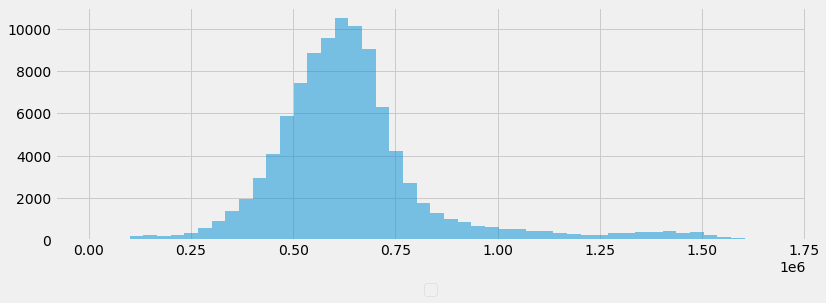

In [15]:
%%time
counter_list = []

for feature2 in distribution_features[1:]:
    feature1 = distribution_features[0]
    df, counter = distribution_count(train, dev, feature1, feature2, bins=20)
    counter_list.append(counter)
    
    # display example    
    if feature2 == 'gfs_temperature_sea':
        print('\n\nExample table')    
        display(df)
    
counter = pd.concat(counter_list, axis=1).sum(axis=1)
fast_hist(counter, bins=50)

In [16]:
std_rate = 0.443

uncertainties4_dev = np.log1p(np.log1p(uncertainties_dev.copy()))
uncertainties4_dev /= np.median(uncertainties4_dev)
uncertainties4_dev = uncertainties4_dev + preds_std_dev / np.median(preds_std_dev) * std_rate 

df, score = calculate_score(dev[target], avg_preds_dev, uncertainties4_dev)
score

1.0418552563285446

,distribution_rate,score
89,1.909091e-07,1.038966


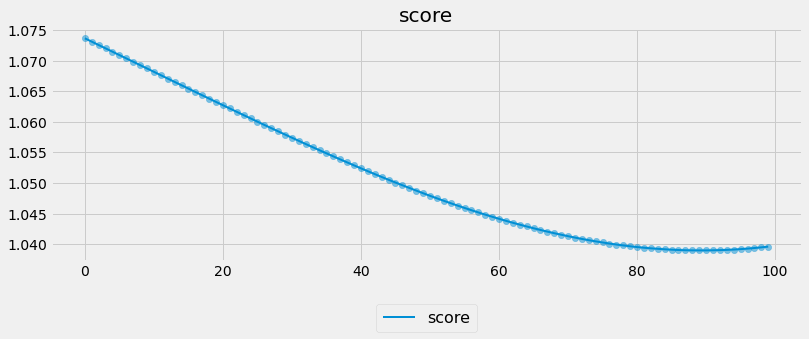

In [17]:
rate_df = pd.DataFrame(np.linspace(0.000001, 0.0000001, 100), columns=['distribution_rate'])
rate_df['score'] = np.NaN

for row in range(rate_df.shape[0]):
    rate = rate_df['distribution_rate'].iloc[row]
    df, score = calculate_score(dev[target], avg_preds_dev, uncertainties4_dev - counter * rate)
    rate_df.loc[row, 'score'] = score

fast_plot(rate_df['score'])
mask = rate_df['score'] == rate_df['score'].min()
rate_df[mask]

## Submit

In [18]:
%%time
uncert_preds = get_all_predictions_mixed(test[features], uncert_orange, test[features2], uncert_bronze)
all_uncertainty = ensemble_uncertainties_regression(uncert_preds)
uncertainties = all_uncertainty['tvar']

Wall time: 1min 33s


In [19]:
%%time
all_preds = get_all_predictions_mixed(test[features], rmse_purple_aqua, test[features2], rmse_silver)
avg_preds = np.squeeze(np.mean(all_preds, axis=0))
preds_std = all_preds.std(axis=0)

Wall time: 12min 45s


In [20]:
std_rate = 0.443

uncertainties4 = np.log1p(np.log1p(uncertainties.copy()))
uncertainties4 /= np.median(uncertainties4)
uncertainties4 = uncertainties4 + preds_std / np.median(preds_std) * std_rate

['x1', 'wrf_t2']
['x1', 'x2']
['x1', 'gfs_temperature_sea']
['x1', 'cmc_0_0_0_2_interpolated']
['x1', 'gfs_temperature_sea_interpolated']
['x1', 'wrf_t2_interpolated']
['x1', 'cmc_0_0_0_1000']
['x1', 'topography_bathymetry']
['x1', 'cmc_0_0_0_2']
['x1', 'sun_elevation']
['x1', 'gfs_pressure']
['x1', 'gfs_soil_temperature']
['x1', 'climate_pressure']
['x1', 'cmc_0_3_0_0_next']
['x1', 'wrf_rh2']
['x1', 'climate_temperature']
['x1', 'cmc_0_0_0_2_grad']
['x1', 'gfs_temperature_10000']
['x1', 'gfs_humidity']
['x1', 'cmc_0_1_0_0']
['x1', 'cmc_0_0_7_925']
['x1', 'gfs_wind_speed']
['x1', 'wrf_psfc']
['x1', 'wrf_wind_u']
['x1', 'gfs_temperature_sea_grad']
['x1', 'cmc_timedelta_s']


No handles with labels found to put in legend.


Wall time: 2min 40s


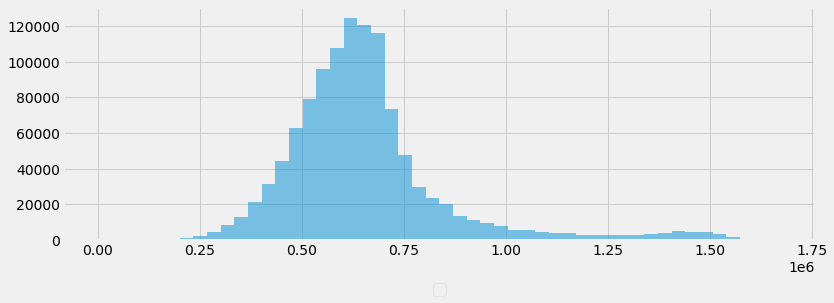

In [21]:
%%time
counter_list_test = []

for feature2 in distribution_features[1:]:
    feature1 = distribution_features[0]
    df, counter = distribution_count(train, test, feature1, feature2, bins=20)
    counter_list_test.append(counter)
    
counter_test = pd.concat(counter_list_test, axis=1).sum(axis=1)
fast_hist(counter_test, bins=50)

In [22]:
rate = 1.909091e-07
final_uncertainties = uncertainties4 - counter * rate

In [23]:
# Prepare the ids
ids = np.arange(1, len(test) + 1)

# Predictions are the mean predictions across the ensemble of models
predictions = avg_preds

df_submission = pd.DataFrame(data={
        'ID' : ids,
        'PRED' : predictions,
        'UNCERTAINTY' : final_uncertainties
        })

display(df_submission.head())
display(df_submission.tail())

out_file = '../data/submissions/submission.csv'
df_submission.to_csv(out_file, index=False)

,ID,PRED,UNCERTAINTY
0,1,3.435913,1.043912
1,2,16.155540,1.237102
2,3,2.456307,1.125766
3,4,2.511512,1.297327
4,5,10.986378,2.043631


,ID,PRED,UNCERTAINTY
1137726,1137727,12.946751,1.395434
1137727,1137728,24.904966,1.038910
1137728,1137729,6.876050,1.194454
1137729,1137730,29.365213,1.061357
1137730,1137731,19.890529,1.360811
